# MACHINE LEARNING WORKFLOW

In [115]:
# Import Libraries/Modules
import pandas as pd
pd.set_option('display.max_colwidth', None)
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")

# 01 Data Preprocessing

In [2]:
# dataset from kaggle
df = pd.read_csv('data.csv', encoding='latin1') 
df.sample(10)

,corpus_name,raw_sentence
780400,sentiment140,"Definitely, definitely investing in some advil pm. Once again, I tried to go 2 sleep @ 10p wake up @ 2:42am. Wtf?"
1253021,sentiment140,@meagansdesigns Thanks
1251425,sentiment140,a free week
1038919,sentiment140,@MariahJade I love how you know what that is
733797,sentiment140,didn't sleep as well as i'd hoped on flight. Tried watching films i thought would put me to sleep but they turned out to be too good
522429,sentiment140,"@alingtron There aren't any in this room anymore. We have a few bites, but thought the web is where you should look for a web person!"
924358,sentiment140,happy mothers day
649192,sentiment140,My man took the laptop. Grrrrrr... Now I have to actually go to the basement to check stuff.
1455975,sentiment140,is thing-king again
1252672,sentiment140,"@AquaticApe and so is Dixie, I'm sure"


In [3]:
# text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, stop_words):
    if text and isinstance(text, str):
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'https?://\S+|www\.\S+|@\w+|#\w+|[^a-zA-Z]', ' ', text.lower())
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if len(word) > 1 and word not in stop_words])
        text = ' '.join(list(dict.fromkeys(text.split())))
    else:
        text = ''
    return text

df['clean_text'] = df['raw_sentence'].apply(clean_text, stop_words=stop_words)
df[['raw_sentence', 'clean_text']].sample(10)

,raw_sentence,clean_text
1113831,Wild Life by Mr. Big on my fingers,wild life mr big finger
1104712,I'm back....don't feel like going to work (wow...what an option? Easy i'm in charge (www.LaughNYC.com),back feel like going work wow option easy charge
1386247,@MarcyChen I know Actually I leave in almost exactly a week. Really excited &amp; don't know what to expect.,know actually leave almost exactly week really excited expect
852348,is having a twitter of a time,twitter time
116033,@JcatJ I'm reading it and starting to cry all over again,reading starting cry
370210,Ahh man twitter will be down 10 pm my time,ahh man twitter pm time
1551269,@shauninman Mint Curry? Have you any Chiptune recommendations?,mint curry chiptune recommendation
239507,"@ann_elizabeth yeah i secretly enjoyed the Chaucer, much more than She Stoops. I have loads of past essay questions but i hate doing them",yeah secretly enjoyed chaucer much stoop load past essay question hate
357441,@Jamie_Spears lucky i only have 16 lol,lucky lol
1582511,"@DistroPa Boinc projects changed over, three clean dogs and two clean kids",boinc project changed three clean dog two kid


In [4]:
# sentiment labeling with textblob analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['textblob_polarity'] = df['clean_text'].apply(get_sentiment).round(2)

def categorize_sentiment(score):
    if score >= 0.5:
        return 'Positive'
    elif score >= 0.05 and score < 0.5:
        return 'Moderately Positive'
    elif score > -0.05 and score < 0.05:
        return 'Neutral'
    elif score > -0.5 and score <= -0.05:
        return 'Moderately Negative'
    else:
        return 'Negative'

df['sentiment_textblob'] = df['textblob_polarity'].apply(categorize_sentiment)
df[['clean_text', 'textblob_polarity', 'sentiment_textblob']].sample(10)

,clean_text,textblob_polarity,sentiment_textblob
363600,home sickkkk work today paint fume gave world worst headache leave alone,-1.00,Negative
861688,new expert show,0.14,Moderately Positive
1136291,thank letting u know bout shack reading love inspireing,0.50,Positive
358242,working go work come back,0.00,Neutral
1098535,late brunch grinding coffee bean baking bread sun,-0.30,Moderately Negative
1156126,another beautiful morning evesham heading shortly ride hopefully leg work properly day,0.28,Moderately Positive
518225,disappointed workshop run known would attended sure,-0.12,Moderately Negative
220520,stress life causing hair fall epic proportion,0.10,Moderately Positive
407051,back dirty spoonless,-0.30,Moderately Negative
451016,gotta wait till tmorrow seems far away ugh need britterz,0.10,Moderately Positive


In [5]:
# calculates sentiment frequency count
df['sentiment_textblob'].value_counts()

Neutral                623173
Moderately Positive    440870
Positive               240435
Moderately Negative    193581
Negative               101940
Name: sentiment_textblob, dtype: int64

In [6]:
# balancing data by sampling
sentiment_counts = df['sentiment_textblob'].value_counts()
min_value = sentiment_counts.min()
balanced_data = pd.DataFrame()

for sentiment in sentiment_counts.index:
    sampled_data = df[df['sentiment_textblob'] == sentiment].sample(min_value, random_state=42)
    balanced_data = balanced_data.append(sampled_data)

balanced_data = balanced_data.sample(frac=1, random_state=42)
balanced_data.reset_index(drop=True, inplace=True)

balanced_data['sentiment_textblob'].value_counts()

Moderately Negative    101940
Neutral                101940
Negative               101940
Positive               101940
Moderately Positive    101940
Name: sentiment_textblob, dtype: int64

# 02 Exploratory Data Analysis

In [52]:
balanced_data.sample(10)

,corpus_name,raw_sentence,clean_text,textblob_polarity,sentiment_textblob
356990,sentiment140,@MCHammer My Pirates are looking sad as ever,pirate looking sad ever,-0.50,Negative
250424,sentiment140,"http://bit.ly/bcHyI I like the layout, too bad it's not customizable..",like layout bad customizable,-0.70,Negative
179592,sentiment140,cancelled the show @ degonz on saturday because some of us are sick. Which sucks,cancelled show degonz saturday u sick suck,-0.71,Negative
393392,sentiment140,Just had my snack.,snack,0.00,Neutral
134816,sentiment140,@meedee64 *snuggles* you be awesome.,snuggle awesome,1.00,Positive
253040,sentiment140,So tired my eyes are blurry but just can't sleep!,tired eye blurry sleep,-0.40,Moderately Negative
444879,sentiment140,unhappy the office is very serius now,unhappy office serius,-0.60,Negative
277909,sentiment140,i made those upp on my own! proud ugh? lol,made upp proud ugh lol,0.80,Positive
477600,sentiment140,goin to go play on mervel with siblings,goin go play mervel sibling,0.00,Neutral
107281,sentiment140,just finished having brunch because of Caro's b-day!,finished brunch caro day,0.00,Neutral


In [57]:
# overview of data
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509700 entries, 0 to 509699
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   corpus_name         509700 non-null  object 
 1   raw_sentence        509700 non-null  object 
 2   clean_text          509700 non-null  object 
 3   textblob_polarity   509700 non-null  float64
 4   sentiment_textblob  509700 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.4+ MB


In [59]:
# check the shape/size of the dataframe
balanced_data.shape

(509700, 5)

In [53]:
# check the statistics
balanced_data.describe()

,textblob_polarity
count,509700.000000
mean,0.009364
std,0.448461
min,-1.000000
25%,-0.300000
50%,0.000000
75%,0.350000
max,1.000000


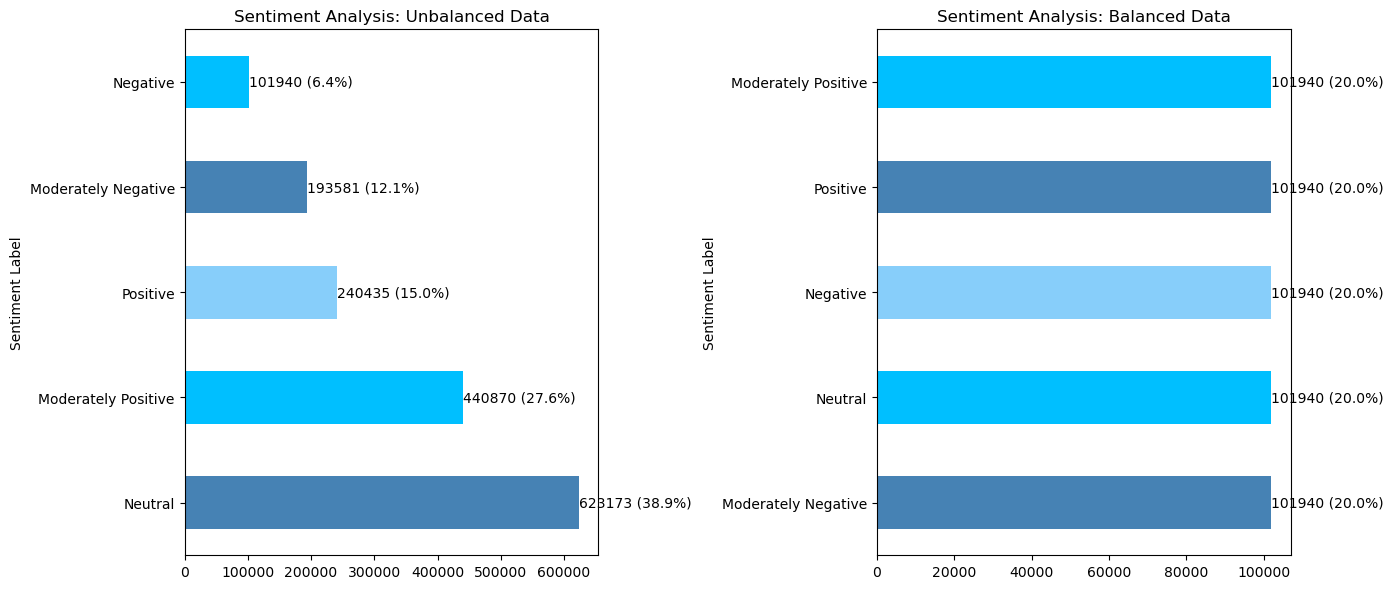

In [63]:
# Create a figure with two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Title and plot for Unbalanced Data
axes[0].set_title("Sentiment Analysis: Unbalanced Data")
axes[0].set_ylabel("Sentiment Label")
unbalanced_counts = df["sentiment_textblob"].value_counts()
total_unbalanced = len(df["sentiment_textblob"])
unbalanced_counts.plot(kind="barh", color=['steelblue', 'deepskyblue', 'lightskyblue'], ax=axes[0])
for i, count in enumerate(unbalanced_counts):
    percentage = (count / total_unbalanced) * 100
    axes[0].text(count, i, f"{count} ({percentage:.1f}%)", va='center')

# Title and plot for Balanced Data
axes[1].set_title("Sentiment Analysis: Balanced Data")
axes[1].set_ylabel("Sentiment Label")
balanced_counts = balanced_data["sentiment_textblob"].value_counts()
total_balanced = len(balanced_data["sentiment_textblob"])
balanced_counts.plot(kind="barh", color=['steelblue', 'deepskyblue', 'lightskyblue'], ax=axes[1])
for i, count in enumerate(balanced_counts):
    percentage = (count / total_balanced) * 100
    axes[1].text(count, i, f"{count} ({percentage:.1f}%)", va='center')

# Adjust the spacing between the plots
plt.tight_layout()

# Display the plots
plt.show()

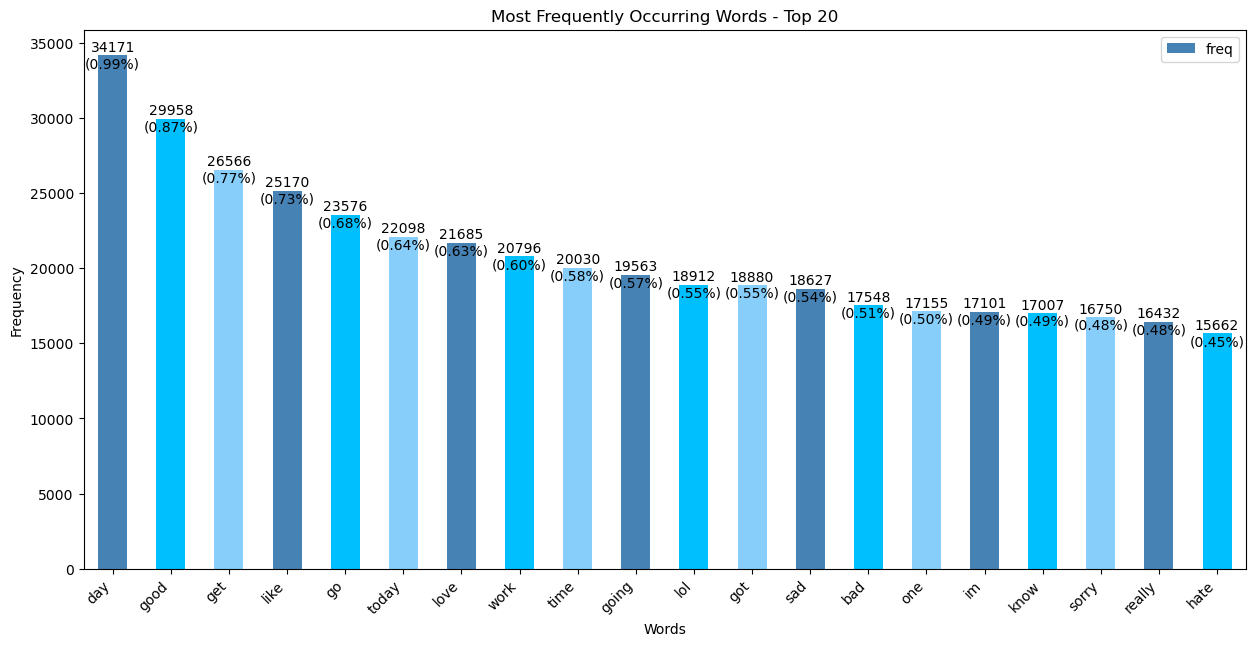

In [76]:


# Fit the CountVectorizer to the balanced data
words = vectorizer.fit_transform(balanced_data.clean_text.values.astype('U'))

# Sum the words frequencies
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

# Calculate the total count of words
total_words = frequency['freq'].sum()

# Select the top 20 most frequently occurring words
top_20 = frequency.head(20)

# Calculate the percentage for each word
top_20['percentage'] = (top_20['freq'] / total_words) * 100

# Plot the bar chart
ax = top_20.plot(x='word', y='freq', kind='bar', figsize=(15, 7), color=['steelblue', 'deepskyblue', 'lightskyblue'])
plt.title("Most Frequently Occurring Words - Top 20")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')

# Display count values and percentages above each bar
for p in ax.patches:
    word = top_20.loc[top_20['freq'] == p.get_height(), 'word'].values[0]
    percentage = top_20.loc[top_20['freq'] == p.get_height(), 'percentage'].values[0]
    ax.annotate(f"{p.get_height():.0f}\n({percentage:.2f}%)",
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.show()

In [81]:
# Random Samples with Positive Sentiment
positive_samples = balanced_data[balanced_data['sentiment_textblob'] == 'Positive'][['clean_text', 'sentiment_textblob']].sample(10)
positive_samples

,clean_text,sentiment_textblob
446033,eating milky way magic star avoid boredom still sign parcel,Positive
267050,thinking bedtime wrote numberous email today feel good connect friend thank god computer,Positive
308428,put rose oil face skin promised make look better yeah,Positive
100972,ok thats whassup im jealous ur still work,Positive
66306,mike best boyfriend could ever wished love much think die without gonna go watch shrek,Positive
86229,good night love football girl,Positive
309416,pic really cute,Positive
363927,college nice sunny day,Positive
204544,good morning love yes tues hoho,Positive
321500,okay mom,Positive


In [82]:
# Random Samples with Negative Sentiment
negative_samples = balanced_data[balanced_data['sentiment_textblob'] == 'Negative'][['clean_text', 'sentiment_textblob']].sample(10)
negative_samples

,clean_text,sentiment_textblob
444990,know huh want see badly,Negative
212732,brrrr wish owned boot tonight cold going,Negative
175753,sweeping garden sadly know meant something else hehe,Negative
50193,nose feel crap bet start cold,Negative
342742,bad tweeterer sunday started coffee,Negative
38235,make sense actually ugly talk delusion,Negative
244576,degree today hate summer,Negative
43026,lost charm beach dirty,Negative
133849,hate chewing gum lost flavour,Negative
230941,two week med dont work ill nite surgery,Negative


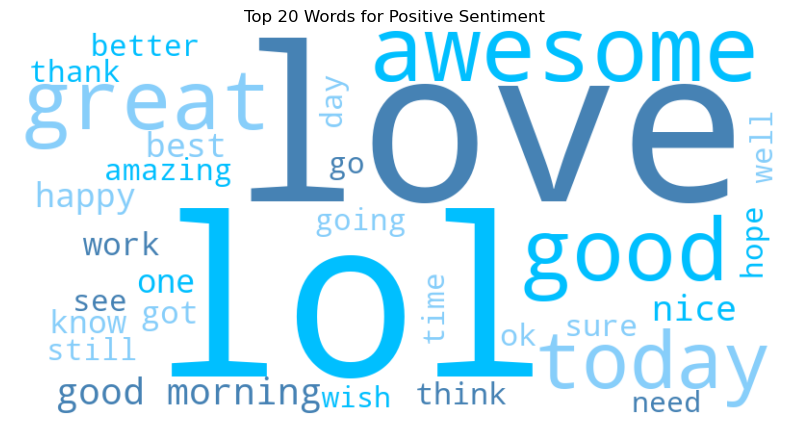

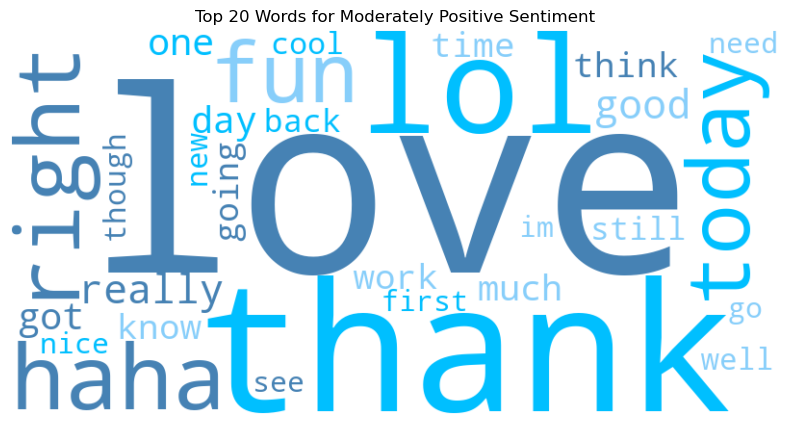

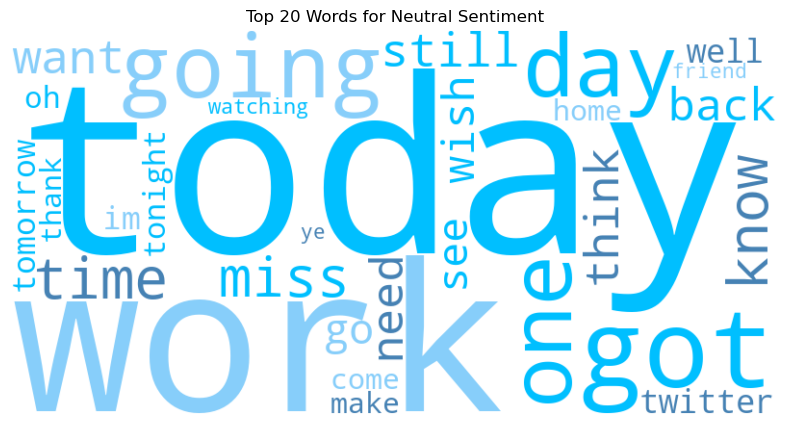

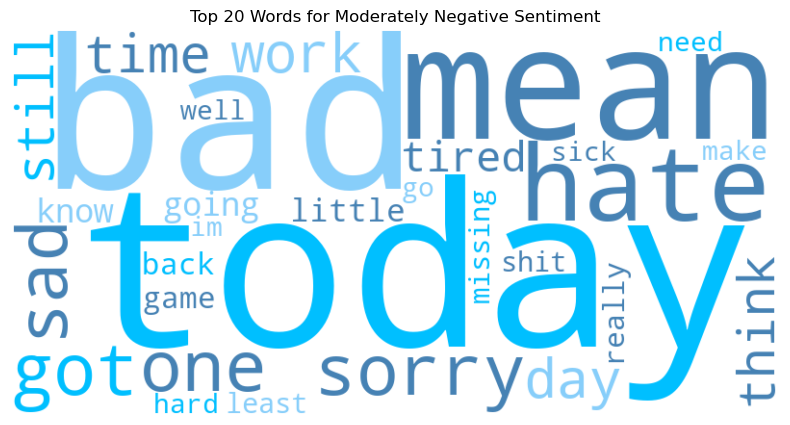

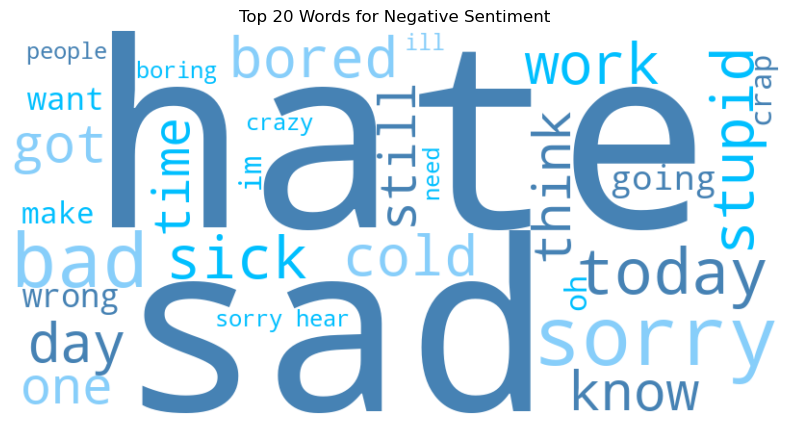

In [110]:
# Shuffle the colors list
colors = ['steelblue', 'deepskyblue', 'lightskyblue']
random.shuffle(colors)

# Create a custom colormap from the shuffled colors list
custom_cmap = ListedColormap(colors)

# Create a word cloud for each sentiment category
sentiment_categories = balanced_data['sentiment_textblob'].unique()

# Sort sentiment categories in order of sentiment: Positive to Negative
sorted_sentiments = ['Positive', 'Moderately Positive', 'Neutral', 'Moderately Negative', 'Negative']

for sentiment in sorted_sentiments:
    # Filter the data for the current sentiment category
    sentiment_data = balanced_data[balanced_data['sentiment_textblob'] == sentiment]
    text = " ".join(sentiment_data['clean_text'])

    # Create and generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=custom_cmap).generate(text)

    # Display the top 30 words for the current sentiment category
    wordcloud_top20 = WordCloud(width=800, height=400, background_color='white', colormap=custom_cmap, max_words=30).generate(text)

    # Plot the word cloud for top 30 words
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_top20, interpolation='bilinear')
    plt.title(f"Top 20 Words for {sentiment} Sentiment")
    plt.axis('off')
    plt.show()

# 03 Feature Engineering

In [7]:
# vectorization model development
vectorizer = CountVectorizer() 

X = vectorizer.fit_transform(balanced_data['clean_text'])
y = balanced_data['sentiment_textblob']

# with open('vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer, f)

# 04 Model Development

In [8]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)
# with open('lr.pkl', 'wb') as f:
#     pickle.dump(lr, f)

LogisticRegression()

In [10]:
# multinomial naive bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# with open('mnb.pkl', 'wb') as f:
#     pickle.dump(mnb, f)

MultinomialNB()

In [13]:
svc = LinearSVC()
svc.fit(X_train, y_train)
# with open('svc.pkl', 'wb') as f:
#     pickle.dump(svc, f)

LinearSVC()

In [15]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
# with open('dtc.pkl', 'wb') as f:
#     pickle.dump(dtc, f)

DecisionTreeClassifier()

# 05 Model Evaluation

In [22]:
# Evaluate the models
models = {
    'Logistic Regression': lr,
    'Multinomial Naive Bayes': mnb,
    'Linear SVC': svc,
    'Decision Tree Classifier': dtc
}

results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)

In [66]:
# Determine the row with the highest accuracy
highest_accuracy_row = evaluation_table.loc[evaluation_table['Accuracy'].idxmax()]

# Function to apply background color based on highest accuracy
def highlight_highest_accuracy(s):
    if s['Accuracy'] == highest_accuracy_row['Accuracy']:
        return ['background-color: lightskyblue'] * len(s)
    else:
        return [''] * len(s)

# Apply background color to the evaluation table
styled_evaluation_table = evaluation_table.style.apply(highlight_highest_accuracy, axis=1)

# Display the styled evaluation table
print("Model Evaluation:")
display(styled_evaluation_table)

Model Evaluation:


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.942908,0.942986,0.942908,0.942893
1,Multinomial Naive Bayes,0.798283,0.807633,0.798283,0.794363
2,Linear SVC,0.902649,0.902688,0.902649,0.902605
3,Decision Tree Classifier,0.922180,0.921992,0.922180,0.921821


In [25]:
# Make predictions on the test data
predictions = lr.predict(X_test)

# Evaluate the performance of the classifier
print(classification_report(y_test, predictions))

                     precision    recall  f1-score   support

Moderately Negative       0.92      0.92      0.92     20537
Moderately Positive       0.93      0.92      0.92     20250
           Negative       0.95      0.97      0.96     20486
            Neutral       0.97      0.94      0.95     20413
           Positive       0.95      0.96      0.96     20254

           accuracy                           0.94    101940
          macro avg       0.94      0.94      0.94    101940
       weighted avg       0.94      0.94      0.94    101940



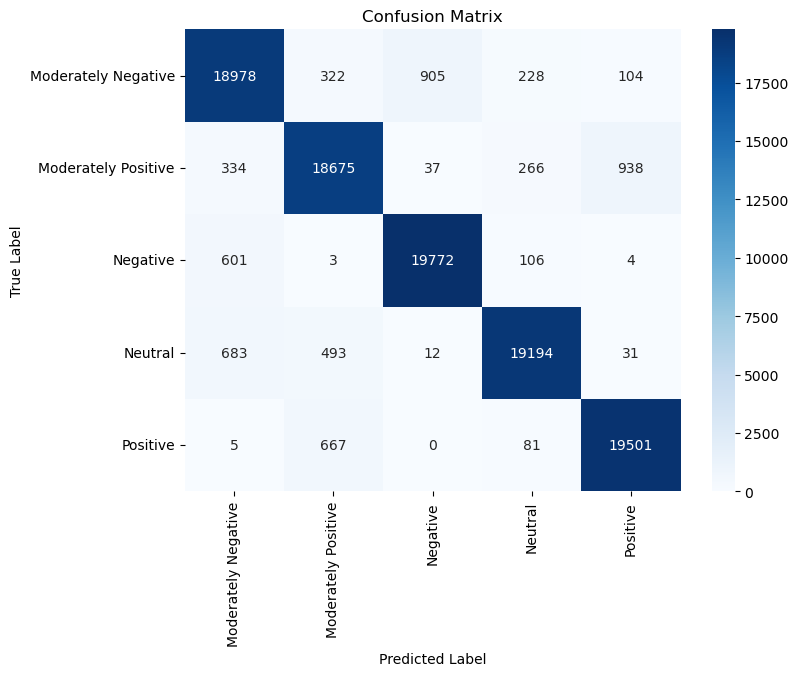

In [117]:
# Create a confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 06 Model Deployment

In [118]:
# Take user input for the text whose sentiment needs to be predicted
user_input = input("Enter the text: ")

# Preprocess the user input
cleaned_sentence = clean_text(user_input, stop_words)

# Use the loaded vectorizer to transform the user input into numerical features
input_features = vectorizer.transform([cleaned_sentence])

# Use the loaded logistic regression model to make the sentiment prediction
predicted_sentiment = model.predict(input_features)[0]

# Get the probability scores for each sentiment category
probability_scores = model.predict_proba(input_features)[0]
probability_scores_dict = {model.classes_[i]: probability_scores[i] for i in range(len(model.classes_))}

# Sort the probability scores from highest to lowest
sorted_probabilities = sorted(probability_scores_dict.items(), key=lambda x: x[1], reverse=True)

print("")

# Display the predicted sentiment and sorted probability scores to the user
print("Predicted Sentiment:", predicted_sentiment)

print("")

for sentiment, score in sorted_probabilities:
    print(f"{sentiment}: {score:.4f}")

Enter the text: i hate spam

Predicted Sentiment: Negative

Negative: 0.9833
Moderately Negative: 0.0162
Neutral: 0.0005
Moderately Positive: 0.0000
Positive: 0.0000
